# This example notebook, uses the provided OGIP files, to plot the Spectral Energy Distribution and Differential Spectrum

One can follow the tutorial from gammapy here https://docs.gammapy.org/0.19/tutorials/analysis/1D/spectral_analysis.html

# This notebook follows the following steps:
## 1. Get the dataset from OGIP files
## 2. Get the reference energy for a Log Parabola model Fit
## 3. Perform Modeling and Fitting and check some statistics
## 4. Plot the various plots
## 5. Save Flux Points Dataset and Models to separate files

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import pickle
from pathlib import Path

import astropy.units as u
from astropy.time import Time
from astropy.io import fits
from astropy.table import Table
import numpy as np

from gammapy.maps import MapAxis
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    LogParabolaSpectralModel,
    create_crab_spectral_model,
    SkyModel,
)
from gammapy.datasets import Datasets, SpectrumDatasetOnOff, FluxPointsDataset

from gammapy.estimators import FluxPointsEstimator

# 1. Get the OGIP files and make some selections if need be

In [2]:
base_dir = "/fefs/aswg/workspace/analysis-school-2022/DL3/"
dir_path = "Crab_src_indep/"

ogip_path = Path(base_dir+dir_path+"OGIP/")

# Create the Paths if they do not exist already
ogip_path.mkdir(exist_ok=True)

In [3]:
# read all obs ids of the pha files in the given directory
obs_ids = []
pha_files = list(ogip_path.glob("obs_*_arf.fits.gz"))
    
for p in pha_files:
    run = int(p.name[4:8])
    obs_ids.append(run)
obs_ids = np.sort(np.array(obs_ids))

In [4]:
# Generate the Datasets object back from the OGIP files
datasets = Datasets()
for obs in obs_ids:
    file = ogip_path / f"obs_{obs}.fits.gz"
    datasets.append(SpectrumDatasetOnOff.read(file))

# 2. Get some parameters to use from the datasets

In [5]:
obj_name = []

for obs in obs_ids:
    file = ogip_path / f"obs_{obs}.fits.gz"
    r = Table.read(file, hdu="REGION").meta
    
    obj_name.append(r["OBJECT"])
print(obs_ids)

obj_name = np.unique(np.array(obj_name))[0]

[2967 2968 2969 2970 2971 2972 2973 2974 2975 2976 2977]


In [6]:
e_reco_edges = datasets[0].counts.geom.axes["energy"].edges

In [7]:
# Energy range for spectral fitting the dataset.
# One can play with different energy bins to check the different spectral fits
e_fit_min = 0.01
e_fit_max = 40

# Using bins per decade
e_fit_bin_p_dec = 5

energy_fit_edges = MapAxis.from_energy_bounds(
    e_fit_min, e_fit_max, 
    nbin=e_fit_bin_p_dec, per_decade=True, 
    unit="TeV"
).edges


# 3. Get Pivot energy to fix the reference energy and define the Spectrum Model

In [8]:
# Find pivot (decorrelation) energy for a Power Law model to get the reference energy for Log Parabola model
def get_pivot_energy(datasets, e_ref, e_edges, obj_name):
    """
    Using Power Law spectral model with the given reference energy and 
    get the decorrelation energy of the fit, within the fit energy range, e_edges
    """
    spectral_model = PowerLawSpectralModel(
        index=2, amplitude=2e-11 * u.Unit("cm-2 s-1 TeV-1"), reference=e_ref
    )
    model = SkyModel(spectral_model=spectral_model, name=obj_name)
    model_check = model.copy()

    # Stacked dataset method
    stacked_dataset = Datasets(datasets).stack_reduce()
    stacked_dataset.models = model_check

    fit_stacked = Fit()
    result_stacked = fit_stacked.run(datasets=stacked_dataset)

    return model_check.spectral_model.pivot_energy


In [9]:
# Using a reference energy close to the expected decorrelation energy
ref = get_pivot_energy(datasets, 0.4 * u.TeV, e_reco_edges, obj_name)
print(ref.to_value(u.GeV))

475.79579463258864


In [10]:
# Final spectral model of Log Parabola, to be used for estimating the LC.
# One can try different Spectral Models as well.
# Be careful in the choice of Spectral Model being used for the 2 examples presented here

# Crab
spectral_model_lp = LogParabolaSpectralModel(
        amplitude = 5e-12 * u.Unit('cm-2 s-1 TeV-1'),
        reference = ref,
        alpha = 2 * u.Unit(''),
        beta = 0.1 * u.Unit('')
)
model_lp = SkyModel(spectral_model=spectral_model_lp, name=obj_name)


In [11]:
# Use the appropriate models, as per the selection of the source/dataset
params=model_lp.to_dict()['spectral']['parameters']
params

[{'name': 'amplitude', 'value': 5e-12, 'unit': 'cm-2 s-1 TeV-1'},
 {'name': 'reference',
  'value': 0.47579579463258864,
  'unit': 'TeV',
  'frozen': True},
 {'name': 'alpha', 'value': 2.0},
 {'name': 'beta', 'value': 0.1}]

# 4. Spectral Fitting
One can check for a more comprehensive tutorial on Modelling and Fitting, here are the gammapy tutorials -
* https://docs.gammapy.org/0.19/tutorials/api/fitting.html
* https://docs.gammapy.org/0.19/tutorials/api/model_management.html

In [12]:
# Using stacked analysis method, where we stack together all Datasets into 1 Dataset and add the model afterwards
stacked_dataset = Datasets(datasets).stack_reduce()
stacked_dataset.models = model_lp

In [13]:
# Fitting the model to the dataset
fit = Fit()
result = fit.run(datasets=stacked_dataset)
model_best = model_lp.copy() # creating a copy of the model, to avoid overwriting of the original object

In [14]:
# Compute the Flux Points after Fitting the model
# We do not do too many optimizations here. 
# If one wants, can try and check the various attributes of the Estimator
fpe = FluxPointsEstimator(
    energy_edges=energy_fit_edges, 
    reoptimize = False, # Re-optimizing other free model parameters (not belonging to the source)
    source=obj_name,
    selection_optional="all" # Estimates asymmetric errors, upper limits and fit statistic profiles
)
flux_points = fpe.run(datasets=stacked_dataset)

flux_points_dataset = FluxPointsDataset(
    data=flux_points, models=model_best
)

In [15]:
result
# Gammapy bug, which will be fixed in the next release

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 213
	total stat : 7.79

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 213
	total stat : 7.79


In [16]:
model_best.to_dict()['spectral']['parameters']

[{'name': 'amplitude',
  'value': 1.7518325507674288e-10,
  'unit': 'cm-2 s-1 TeV-1',
  'error': 4.949293274342747e-12},
 {'name': 'reference',
  'value': 0.47579579463258864,
  'unit': 'TeV',
  'frozen': True},
 {'name': 'alpha', 'value': 2.325421008380945, 'error': 0.026755115362972065},
 {'name': 'beta', 'value': 0.06972637228927822, 'error': 0.017179151944931963}]

In [17]:
print(flux_points)

FluxPoints
----------

  geom                   : RegionGeom
  axes                   : ['lon', 'lat', 'energy']
  shape                  : (1, 1, 19)
  quantities             : ['norm', 'norm_err', 'norm_errn', 'norm_errp', 'norm_ul', 'ts', 'npred', 'npred_excess', 'stat', 'counts', 'success', 'stat_scan']
  ref. model             : lp
  n_sigma                : 1
  n_sigma_ul             : 2
  sqrt_ts_threshold_ul   : 2
  sed type init          : likelihood



# 5. Check some features of the Flux points

In [18]:
# Check the Flux table
# sed_type options are {“likelihood”, “dnde”, “e2dnde”, “flux”, “eflux”} with "likelihood" being default
# format options are {“gadf-sed”, “lightcurve”, “binned-time-series”, “profile”} with "gadf-sed" being default
flux_points.to_table(formatted=True, sed_type="e2dnde")

e_ref,e_min,e_max,e2dnde,e2dnde_err,e2dnde_errp,e2dnde_errn,e2dnde_ul,ts,sqrt_ts,npred [1],npred_excess [1],stat,is_ul,counts [1],success,norm_scan [11],stat_scan [11]
TeV,TeV,TeV,TeV / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,bool,float64,bool,float64,float64
0.012,0.010,0.015,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.000,False,0.0,False,0.200 .. 5.000,nan .. nan
0.019,0.015,0.024,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.000,False,0.0,False,0.200 .. 5.000,nan .. nan
0.030,0.024,0.037,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.000,False,0.0,False,0.200 .. 5.000,nan .. nan
0.046,0.037,0.057,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.000,False,0.0,False,0.200 .. 5.000,nan .. nan
0.071,0.057,0.089,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.000,False,0.0,False,0.200 .. 5.000,nan .. nan
0.110,0.089,0.137,5.594e-11,5.905e-12,5.905e-12,5.904e-12,6.775e-11,89.796,9.476,17163.999288541745,1710.9987,0.000,False,17164.0,True,0.200 .. 5.000,57.972 .. 1338.711
0.171,0.137,0.212,4.938e-11,3.376e-12,3.377e-12,3.375e-12,5.614e-11,214.481,14.645,7562.9710690414995,1694.9486,0.000,False,7563.0,True,0.200 .. 5.000,134.508 .. 3293.537
0.264,0.212,0.329,4.749e-11,2.554e-12,2.556e-12,2.552e-12,5.261e-11,348.671,18.673,4293.992538043787,1558.9878,0.000,False,4294.0,True,0.200 .. 5.000,225.101 .. 4004.811


In [19]:
# Fit Statistic array
print(flux_points_dataset.stat_array())

# Total statistics sum
print(flux_points_dataset.stat_sum(), np.nansum(flux_points_dataset.stat_array()))

[       nan        nan        nan        nan        nan 0.02651217
 0.37665004 0.05649163 0.11486448 0.07574174 0.06551641 0.28401459
 0.65322061 2.17645529 0.34829633 0.06014367 1.21561409 2.23949139
 0.10787751]
nan 7.800889964284552


In [20]:
model_best.parameters.to_table()

type,name,value,unit,error,min,max,frozen,link
str8,str9,float64,str14,float64,float64,float64,bool,str1
spectral,amplitude,1.7518e-10,cm-2 s-1 TeV-1,4.949e-12,nan,nan,False,
spectral,reference,4.7580e-01,TeV,0.000e+00,nan,nan,True,
spectral,alpha,2.3254e+00,,2.676e-02,nan,nan,False,
spectral,beta,6.9726e-02,,1.718e-02,nan,nan,False,


# 6. Spectral plots

In [21]:
if obj_name == 'Crab':
    ref_label="MAGIC LP (JHEAp 2015)"
else:
    ref_label="Crab MAGIC LP (JHEAp 2015)"

In [22]:
%%time
# Setting plot axes limits and other args
e_plot_min = 0.01 * u.TeV
e_plot_max = 40 * u.TeV

ds_kwargs = {
    "sed_type": "dnde",
    "energy_bounds": [e_plot_min, e_plot_max],
    "yunits": u.Unit("erg-1 cm-2 s-1"),
}
sed_kwargs = {
    "sed_type": "e2dnde",
    "energy_bounds": [e_plot_min, e_plot_max],
    "yunits": u.Unit("erg cm-2 s-1"),

}
sed_plot_kwargs = {
    "label": "LST-1 data",
}
plot_ts_kwargs = {
    "color": "darkorange"
}

CPU times: user 1.16 ms, sys: 50 µs, total: 1.21 ms
Wall time: 1.23 ms


Text(0.5, 1.0, 'TS Profiles')

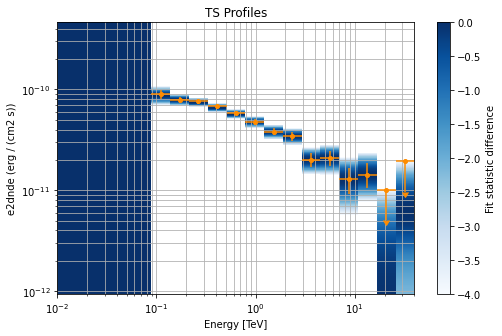

In [23]:
plt.figure(figsize=(8,5))
ax = flux_points.plot(sed_type="e2dnde", **plot_ts_kwargs)

flux_points.plot_ts_profiles(ax=ax, sed_type="e2dnde")

plt.grid(which='both')
plt.title('TS Profiles')

<AxesSubplot:>

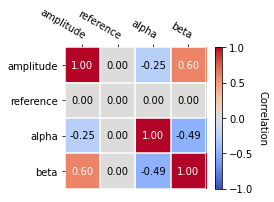

In [24]:
# Fit model covariance matrix plot
model_best.covariance.plot_correlation()

(0.01, 40.0)

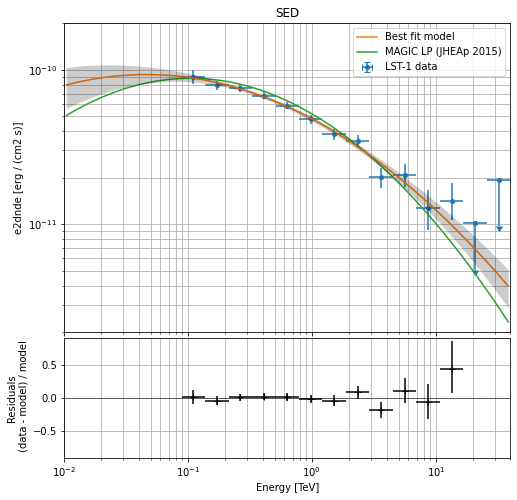

In [25]:
fig_sed = plt.figure(figsize=(8,8))

gs2 = GridSpec(7, 1)

gs2.update(hspace=0.1)
args1 = [gs2[:5,:]]
args2 = [gs2[5:,:]]

fig_gs1 = fig_sed.add_subplot(*args1)
fig_gs2 = fig_sed.add_subplot(*args2)

FluxPointsDataset(data=flux_points, models=model_best).plot_spectrum(
    ax=fig_gs1, 
    kwargs_fp=sed_plot_kwargs, 
)

create_crab_spectral_model("magic_lp").plot(
    ax=fig_gs1, **sed_kwargs, label=ref_label
)

fig_gs1.legend()
fig_gs1.set_xlim(e_plot_min.value, e_plot_max.value)
fig_gs1.set_ylim(2e-12, 2e-10)
fig_gs1.tick_params(labelbottom=False)

fig_gs1.grid(which='both')
fig_gs1.set_title('SED')

flux_points_dataset.plot_residuals(ax=fig_gs2, method='diff/model')
fig_gs2.grid(which='both')
fig_gs2.set_xlim(e_plot_min.value, e_plot_max.value)

Text(0, 0.5, 'Residuals \n (data-model)/sqrt(model)')

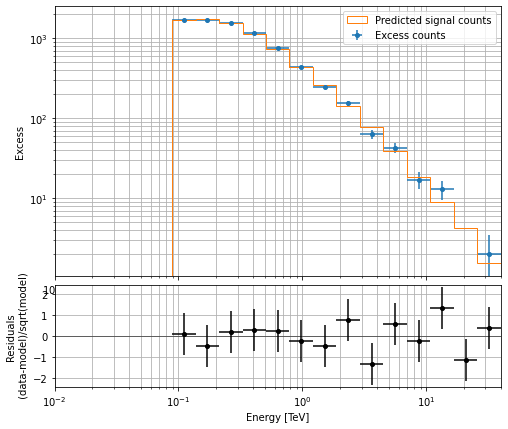

In [26]:
fig = plt.figure(figsize=(8,7))
gs = GridSpec(7, 1)

args1 = [gs[:5,:]]
args2 = [gs[5:,:]]
kwargs_res = {"method": "diff/sqrt(model)"}

fig_gs1 = fig.add_subplot(*args1)
fig_gs2 = fig.add_subplot(*args2)

stacked_dataset.plot_excess(fig_gs1)
fig_gs1.grid(which="both")
fig_gs1.set_ylabel("Excess")

stacked_dataset.plot_residuals_spectral(fig_gs2, **kwargs_res, region=stacked_dataset.counts.geom.region)
fig_gs2.grid(which="both")

fig_gs2.set_ylabel(f"Residuals \n (data-model)/sqrt(model)")

Text(0.5, 1.0, 'Differential spectrum')

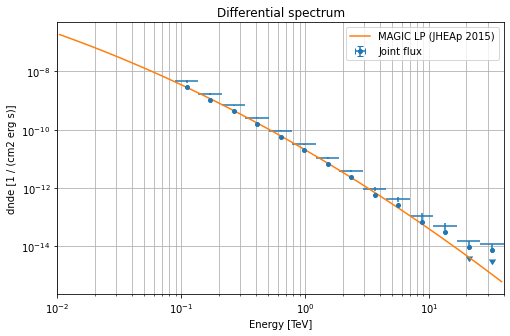

In [27]:
plt.figure(figsize=(8,5))

flux_points.plot(label='Joint flux')
create_crab_spectral_model("magic_lp").plot(**ds_kwargs, label=ref_label)
plt.grid(which='both')
plt.legend()
plt.title('Differential spectrum')

# 7. Save the Flux Points Dataset and Model to separate files

In [28]:
flux_points.write(
    base_dir + dir_path + f'{obj_name}_dataset_{datasets[0].name}_to_{datasets[-1].name}_flux_pts.fits', 
    overwrite=True
)

# write the model to a dict and then to a file
model_dict = model_best.to_dict(full_output='True')

f = open(base_dir + dir_path + f'{obj_name}_dataset_{datasets[0].name}_to_{datasets[-1].name}_flux_model_dict.dat', 'wb')

pickle.dump(model_dict, f)
f.close()